#  

In [1]:
import cvxpy as cp
from copy import deepcopy as copy
from scipy.linalg import fractional_matrix_power, block_diag
import networkx as nx
import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np
from operator import itemgetter
# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
import scipy 
from numpy.linalg import matrix_rank as rank 
from Adversary import Problem, to_str, visualize, Adversary, hamming_dist as dist
from Solvers import type_mask, partial, ket, instance_mask, adv_solver
from Examples import exact_k, threshold_k
from functools import reduce
from itertools import product

In [2]:
def partial_identity(size, id_size, index):
    sub_mat = np.zeros((size, size))
    sub_mat[index, index] = 1
    return np.kron(sub_mat, np.eye(id_size))

def delta_mat(x, y, lang_size):
    n = len(x)
    mat = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if x[i] == x[j]:
                mat[i,j] = 1
    loc_mat = np.zeros((lang_size, lang_size))
    loc_mat[i,j] = 1
    return np.kron(loc_mat, mat)


def partial_transpose(mat, dim1=None, dim2=None):
    assert mat.shape[0] == mat.shape[1]
    mat_size = mat.shape[0]
    if dim1 is None:
        size = int(np.sqrt(mat_size))  
        dim1 = size
        dim2 = size
        
    elif dim2 is None:
        dim2 = mat_size // dim1
    
    assert dim2 * dim1 == mat_size, ("dim1=" + str(dim1) + ", dim2=" + 
                                     str(dim2) +", mat_size=" + str(mat_size))
    
    pt_mat = cp.bmat(
        [
            [
                mat[i*dim2:(i+1)*dim2, j*dim2:(j+1)*dim2].T for i in range(dim1)
            ] for j in range(dim1)
        ]
    )

    return pt_mat
        
def ppt_span_bound(problem, p, r):
    n = problem.n
    lang_size = problem.len
    orig_size = n * lang_size
    pure_size = orig_size * r
    sep_size = pure_size * pure_size 
    print("sep_size", sep_size, pure_size, orig_size, lang_size, n)
    X = cp.Variable((sep_size, sep_size), PSD=True)
    D = [partial_identity(lang_size, n, i) for i in range(lang_size)]
    Delta = [delta_mat(inst1, inst2, problem.len) for inst1, inst2 in 
        list(product(problem.yes_instances, problem.no_instances))
        ]
    
    big_D = [reduce(np.kron, 
                    [d, np.eye(r), np.ones((pure_size, pure_size))]) - np.eye(sep_size)/lang_size for d in D]
    big_Delta = [reduce(np.kron, [mat, np.eye(r), np.ones((pure_size, pure_size))]) - p*np.eye(sep_size) for mat in Delta]
    constraints = [cp.trace(X)==1, partial_transpose(X) >> 0]
    partial_inner = partial_inner_mat([pure_size, pure_size], 0)

    constraints += [
        partial_inner @ cp.multiply(mat, X) @ partial_inner.T == 0 for mat in big_Delta
    ] 

    opt_prob = cp.Problem(cp.Minimize(0), constraints)
    opt_prob.solve(solver="SCS", verbose=True)
    return X.value

def partial_inner_mat(dims, i):
    left_I = np.eye(int(np.prod(dims[:i])))
    right_I = np.eye(int(np.prod(dims[i+1:])))
    left = reduce(np.kron, [left_I, np.ones((1, dims[i])), right_I])
    right = reduce(np.kron, [left_I, np.ones((dims[i], 1)), right_I])
    # print(big_A.shape, B.shape, left.shape, right.shape)
    return left 
#<A,B>
def inner_mats(A,B):
    C = A*B
    return (np.ones((1, A.shape[1])) @ C @  np.ones((B.shape[0], 1)))[0,0]
    
# A is dims[i] by dims[i], B is \otimes_j dims[j] square
# want to apply <A,.> to the ith component of B  

    

In [ ]:
prob = threshold_k(3,2)

X = ppt_span_bound(prob,1.7, 2)
print(np.trace(X))

sep_size 1296 36 18 6 3
                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Nov 17 02:22:55 PM: Your problem has 1679616 variables, 11 constraints, and 0 parameters.
(CVXPY) Nov 17 02:22:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 17 02:22:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 17 02:22:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 17 02:22:55 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 17 02:22:55 PM: Compiling prob

0.12357044921616976


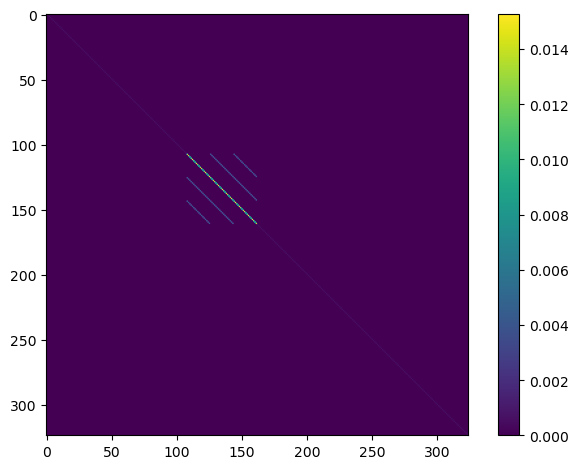

In [19]:
print(np.linalg.norm(X))
visualize(X)
